<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62363 entries, 0 to 62362
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       62363 non-null  object 
 1   location_name                 62363 non-null  object 
 2   latitude                      62363 non-null  float64
 3   longitude                     62363 non-null  float64
 4   timezone                      62363 non-null  object 
 5   last_updated_epoch            62363 non-null  int64  
 6   last_updated                  62363 non-null  object 
 7   temperature_celsius           62363 non-null  float64
 8   temperature_fahrenheit        62363 non-null  float64
 9   condition_text                62363 non-null  object 
 10  wind_mph                      62363 non-null  float64
 11  wind_kph                      62363 non-null  float64
 12  wind_degree                   62363 non-null  int64  
 13  w

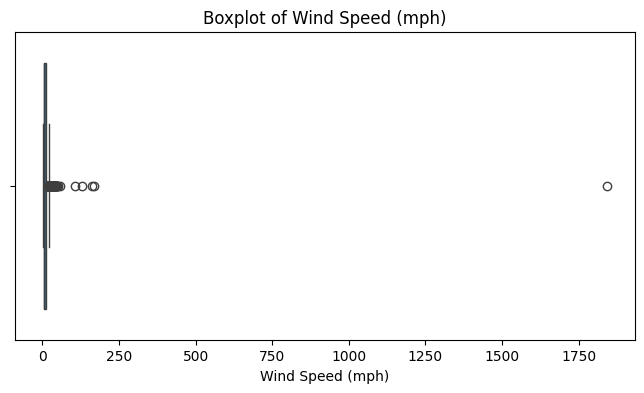

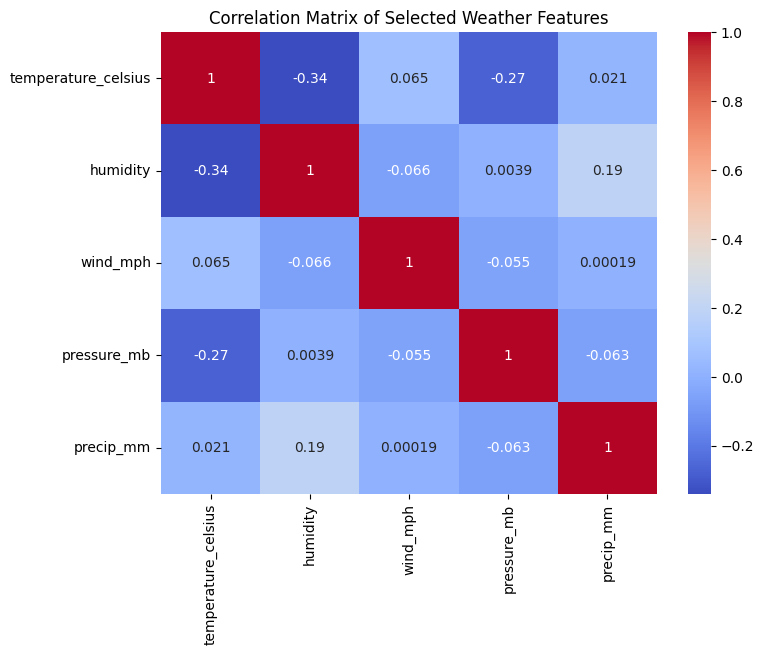

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('GlobalWeatherRepository.csv')

# Display basic info and summary statistics
print(df.info())

# Boxplot to identify potential outliers in wind speed
plt.figure(figsize=(8,4))
sns.boxplot(x=df['wind_mph'])
plt.title('Boxplot of Wind Speed (mph)')
plt.xlabel('Wind Speed (mph)')
plt.show()

# Correlation heatmap of selected features
features = ['temperature_celsius', 'humidity', 'wind_mph', 'pressure_mb', 'precip_mm']
plt.figure(figsize=(8,6))
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Weather Features')
plt.show()


Number of anomalies detected: 624


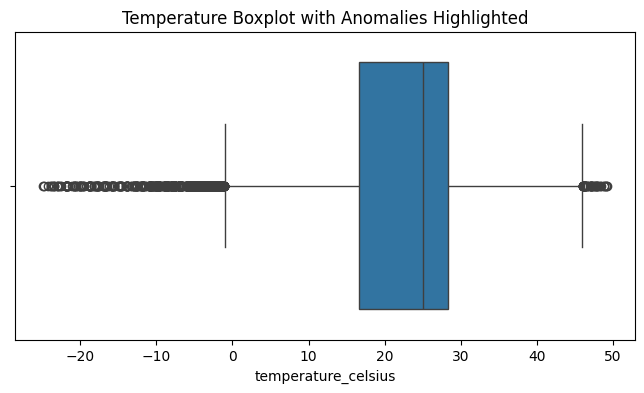

In [3]:
from sklearn.ensemble import IsolationForest

# Select features relevant for anomaly detection
features = ['temperature_celsius', 'humidity', 'wind_mph', 'pressure_mb']
X = df[features]

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso_forest.fit_predict(X)

# Mark anomalies
anomalies = df[df['anomaly'] == -1]
print("Number of anomalies detected:", anomalies.shape[0])

# Visualize anomalies vs. normal observations for temperature
plt.figure(figsize=(8,4))
sns.boxplot(x=df['temperature_celsius'])
plt.title('Temperature Boxplot with Anomalies Highlighted')
plt.show()

Building and comparing multiple forecasting models.

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# --- Data Preparation ---
df['last_updated'] = pd.to_datetime(df['last_updated'])
df_country = df[df['country'] == 'United States of America'].copy()
df_country = df_country.set_index('last_updated')
df_country = df_country.sort_index()
df_country = df_country[~df_country.index.duplicated(keep='first')]
df_country = df_country.asfreq('H')
numeric_cols = df_country.select_dtypes(include=['number']).columns
df_country[numeric_cols] = df_country[numeric_cols].interpolate(method='time')

# Split into train and test sets (80/20 split)
train_size = int(len(df_country) * 0.8)
train = df_country.iloc[:train_size]
test = df_country.iloc[train_size:]
forecast_steps = len(test)

# --- Model 1: ARIMA Forecasting ---
arima_model = ARIMA(train['temperature_celsius'], order=(5,1,0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=forecast_steps)

# --- Model 2: SARIMAX Forecasting ---
sarima_model = SARIMAX(train['temperature_celsius'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# --- Model 3: Random Forest Regressor Forecasting ---
def create_lag_features(series, lags=[1,2,3]):
    df_temp = pd.DataFrame(series)
    for lag in lags:
        df_temp[f'lag_{lag}'] = df_temp['temperature_celsius'].shift(lag)
    return df_temp.dropna()

rf_df = create_lag_features(train['temperature_celsius'])
X_rf = rf_df.drop('temperature_celsius', axis=1)
y_rf = rf_df['temperature_celsius']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y_rf)

rf_forecast = []
last_values = list(train['temperature_celsius'][-3:])  # using last 3 values as initial lag values
for _ in range(forecast_steps):
    X_pred = pd.DataFrame([last_values[-3:]], columns=X_rf.columns)
    y_pred = rf_model.predict(X_pred)[0]
    rf_forecast.append(y_pred)
    last_values.append(y_pred)
rf_forecast = pd.Series(rf_forecast, index=test.index)

# --- Evaluate Individual Models ---
test_actual = test['temperature_celsius']
mae_arima = mean_absolute_error(test_actual, arima_forecast)
mae_sarima = mean_absolute_error(test_actual, sarima_forecast)
mae_rf = mean_absolute_error(test_actual, rf_forecast)


print("ARIMA MAE:", mae_arima)
print("SARIMAX MAE:", mae_sarima)
print("Random Forest MAE:", mae_rf)

# --- Weighted Ensemble Forecast ---

w_arima = 1 / mae_arima
w_sarima = 1 / mae_sarima
w_rf = 1 / mae_rf

total_weight = w_arima + w_sarima + w_rf + w_es
w_arima /= total_weight
w_sarima /= total_weight
w_rf /= total_weight
w_es /= total_weight

print("Ensemble Weights -> ARIMA: {:.2f}, SARIMAX: {:.2f}, RF: {:.2f}, ES: {:.2f}".format(w_arima, w_sarima, w_rf, w_es))

ensemble_forecast = (w_arima * arima_forecast +
                     w_sarima * sarima_forecast +
                     w_rf * rf_forecast +
                     w_es * es_forecast)

mae_ensemble = mean_absolute_error(test_actual, ensemble_forecast)
print("Weighted Ensemble MAE:", mae_ensemble)


<ipython-input-26-fa05b70f1a4e>:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_country = df_country.asfreq('H')


ARIMA MAE: 0.9517949680106441
SARIMAX MAE: 1.2461186211544801
Random Forest MAE: 1.9198717801835095
Exponential Smoothing MAE: 0.8936669113182385
Ensemble Weights -> ARIMA: 0.30, SARIMAX: 0.23, RF: 0.15, ES: 0.32
Weighted Ensemble MAE: 1.012518498447559


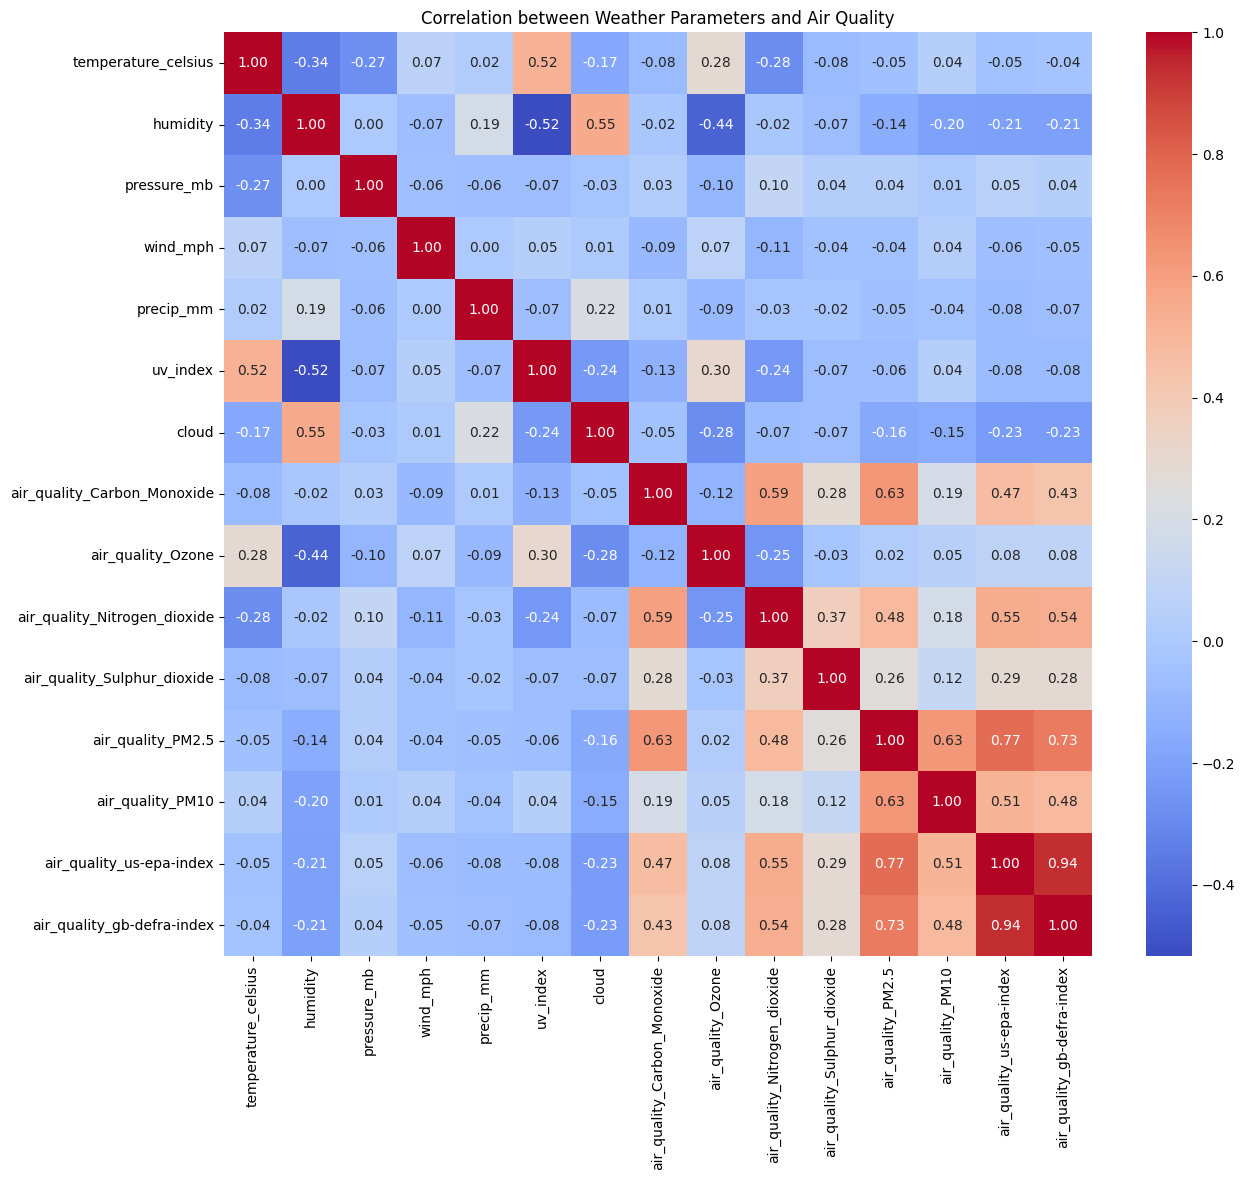

In [27]:
# Defining weather parameters and air quality parameters.
weather_cols = ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_mph', 'precip_mm', 'uv_index', 'cloud']
air_quality_cols = [
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
    'air_quality_PM2.5', 'air_quality_PM10',
    'air_quality_us-epa-index', 'air_quality_gb-defra-index'
]

# Ensure the columns exist in the dataframe.
selected_cols = [col for col in weather_cols + air_quality_cols if col in df.columns]
df_subset = df[selected_cols].dropna()  # Drop rows with missing values

# --- Compute Correlation Matrix ---
corr_matrix = df_subset.corr()

# --- Visualize with a Heatmap ---
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Weather Parameters and Air Quality")
plt.show()

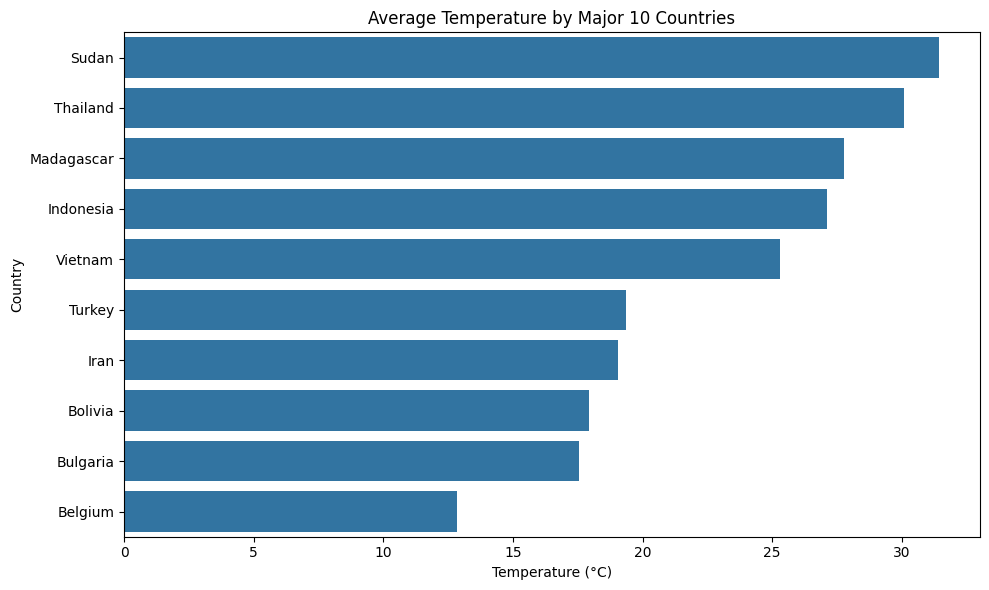

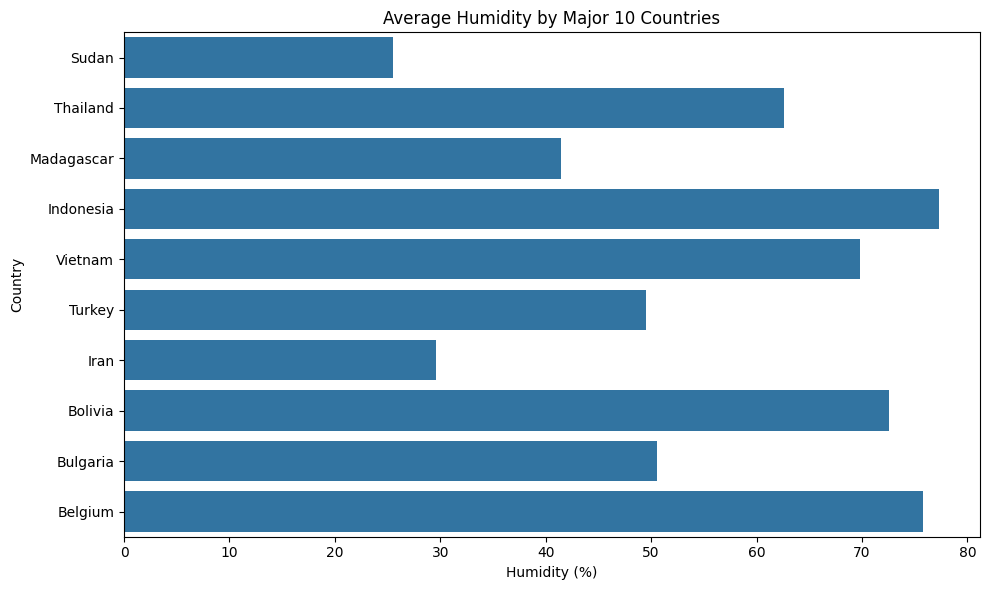

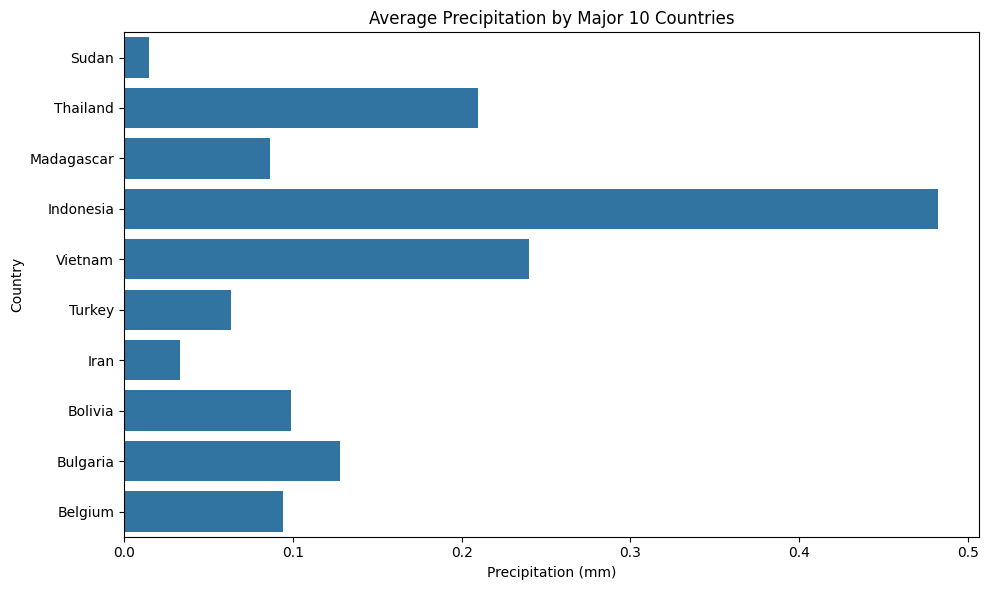

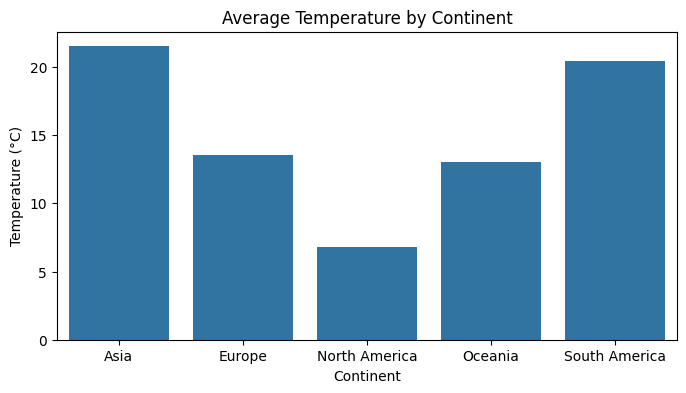

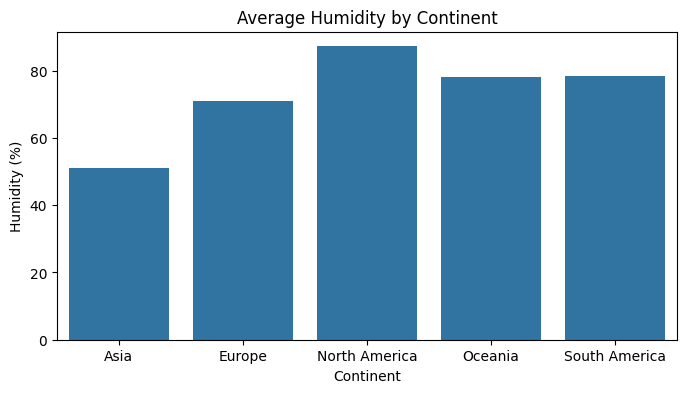

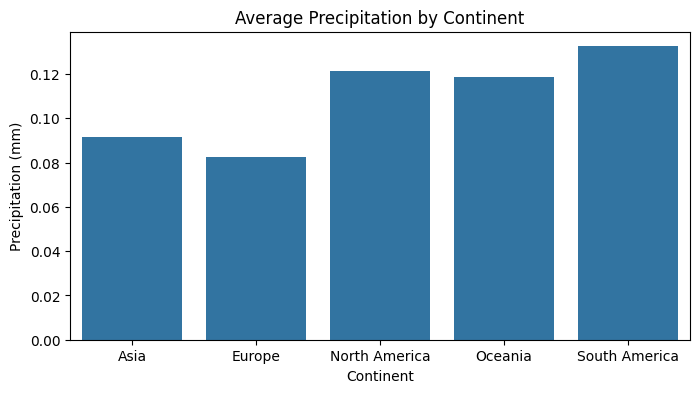

In [31]:
weather_country = df.groupby("country")[['temperature_celsius', 'humidity', 'precip_mm']].mean().reset_index()

major_countries = df['country'].value_counts().nlargest(10).index.tolist()

# Filter to include only these major countries.
weather_country_top10 = weather_country[weather_country['country'].isin(major_countries)]

# Sort the data by temperature for better visualization.
weather_country_top10 = weather_country_top10.sort_values("temperature_celsius", ascending=False)

# Plot average temperature by major 10 countries.
plt.figure(figsize=(10, 6))
sns.barplot(x="temperature_celsius", y="country", data=weather_country_top10)
plt.title("Average Temperature by Major 10 Countries")
plt.xlabel("Temperature (°C)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Similarly, plot average humidity.
plt.figure(figsize=(10, 6))
sns.barplot(x="humidity", y="country", data=weather_country_top10)
plt.title("Average Humidity by Major 10 Countries")
plt.xlabel("Humidity (%)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Plot average precipitation by country.
# And plot average precipitation.
plt.figure(figsize=(10, 6))
sns.barplot(x="precip_mm", y="country", data=weather_country_top10)
plt.title("Average Precipitation by Major 10 Countries")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


# Create a sample mapping from country to continent.
country_to_continent = {
    'United States of America': 'North America',
    'Canada': 'North America',
    'Brazil': 'South America',
    'Argentina': 'South America',
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'France': 'Europe',
    'India': 'Asia',
    'China': 'Asia',
    'Japan': 'Asia',
    'Australia': 'Oceania',
    'New Zealand': 'Oceania'
}

# Map the 'country' column to a new 'continent' column.
df['continent'] = df['country'].map(country_to_continent)

# Drop rows where continent mapping is missing.
df_continent = df.dropna(subset=['continent'])

# Group by continent: Calculate average weather conditions.
weather_continent = df_continent.groupby("continent")[['temperature_celsius', 'humidity', 'precip_mm']].mean().reset_index()

# Plot average temperature by continent.
plt.figure(figsize=(8, 4))
sns.barplot(x="continent", y="temperature_celsius", data=weather_continent)
plt.title("Average Temperature by Continent")
plt.xlabel("Continent")
plt.ylabel("Temperature (°C)")
plt.show()

# Plot average humidity by continent.
plt.figure(figsize=(8, 4))
sns.barplot(x="continent", y="humidity", data=weather_continent)
plt.title("Average Humidity by Continent")
plt.xlabel("Continent")
plt.ylabel("Humidity (%)")
plt.show()

# Plot average precipitation by continent.
plt.figure(figsize=(8, 4))
sns.barplot(x="continent", y="precip_mm", data=weather_continent)
plt.title("Average Precipitation by Continent")
plt.xlabel("Continent")
plt.ylabel("Precipitation (mm)")
plt.show()